In [45]:
import os
import pandas as pd
import plotting
import importlib
importlib.reload(plotting)
import numpy as np
import matplotlib.pyplot as plt 
pd.set_option("display.max_columns", None)  # show all columns


In [46]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

data_features = pd.read_csv("data/features.csv")
all_num_features = plotting.extract_numerical_features(data_features)

ylabel_name = 'marions_ylabels'
ylabel_to_cluster_num = {'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data
labeled_num_features = plotting.extract_numerical_features(labeled_data)
print(labeled_num_features.columns)

Index(['overall_slope', 'max_depth', 'max_resistance', 'num_peaks',
       'largest_force_drop', 'largest_force_drop_dep',
       'largest_force_drop_res', 'curve_shape', 'first_quarter_slope',
       'second_quarter_slope', 'third_quarter_slope', 'fourth_quarter_slope',
       'res_mean', 'res_variance', 'res_quartile_1', 'res_quartile_2',
       'res_quartile_3', 'res_skew', 'res_kurtosis', 'k_overall', 'k2cm',
       'rsquared', 'work2cm'],
      dtype='object')


# Correlation Matrix

In [47]:
corr_matrix = all_num_features.corr()
corr_matrix.to_csv(f"data/correlation_matrix.csv", index=False)
print(corr_matrix)

                        overall_slope  max_depth  max_resistance  num_peaks  \
overall_slope                1.000000  -0.681208        0.503160  -0.322906   
max_depth                   -0.681208   1.000000       -0.706191   0.552762   
max_resistance               0.503160  -0.706191        1.000000  -0.485887   
num_peaks                   -0.322906   0.552762       -0.485887   1.000000   
largest_force_drop          -0.362542   0.417670       -0.200156   0.626876   
largest_force_drop_dep      -0.385473   0.461244       -0.334771   0.142045   
largest_force_drop_res       0.221086  -0.321074        0.376102  -0.266734   
curve_shape                  0.118847  -0.074130       -0.034539   0.018790   
first_quarter_slope          0.873549  -0.574720        0.439238  -0.242154   
second_quarter_slope         0.930125  -0.600351        0.406654  -0.349748   
third_quarter_slope          0.927907  -0.595905        0.420758  -0.295424   
fourth_quarter_slope         0.685413  -0.585079    

# F-Score (Fisher Score)
Compares how much a feature varies between different classes versus how much it varies within the same class

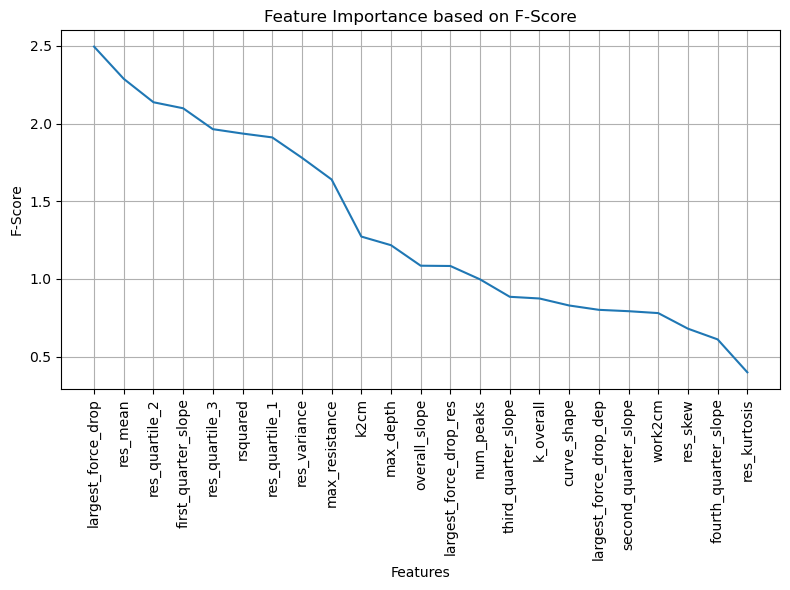

In [48]:
from sklearn.feature_selection import SelectKBest, f_classif

# labeled_data = labeled_data[]    #TODO remove this line
X = labeled_num_features.to_numpy() # numerical features
y = labeled_data[f'{ylabel_name}_nums'].to_numpy() # labels
selector = SelectKBest(score_func=f_classif)
selector.fit(X, y)
scores = selector.scores_

# display results
feature_scores = pd.DataFrame({'Feature': labeled_num_features.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

Fig = plt.figure(figsize=(8, 6))
plt.plot(feature_scores['Feature'], feature_scores['Score'])
plt.xlabel('Features')
plt.ylabel('F-Score')  
plt.title('Feature Importance based on F-Score')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.grid(True)
plt.show()

# Create a list of features sorted based on F-Score & no two features having corr > corr_thresh

In [49]:
def feature_selection(feature_scores, corr_matrix, corr_thresh, desired_features=[], undesired_features=[]):
    optimal_features = []
    if desired_features: optimal_features = desired_features

    for feature in feature_scores['Feature']: # loop through features
        if feature in undesired_features: continue

        above_thresh_mask = corr_matrix[feature].abs() > corr_thresh # get mask of other highly corr features
        above_thresh_mask[feature] = False  # ignore self-correlation
        high_corr_feature_idxs = corr_matrix[above_thresh_mask].index.tolist() # get high corr feature names

        if not any(f in optimal_features for f in high_corr_feature_idxs): # do any of these highly corr features exist in optimal features
            if feature not in optimal_features: # necessary if desired_features
                optimal_features.append(feature) # if not, then add feature to opt list

    return optimal_features

optimal_features = feature_selection(feature_scores, corr_matrix, 0.7, desired_features=['rsquared'], undesired_features=['largest_force_drop']) 
print(optimal_features)

['rsquared', 'res_mean', 'first_quarter_slope', 'k2cm', 'max_depth', 'largest_force_drop_res', 'num_peaks', 'curve_shape', 'largest_force_drop_dep', 'work2cm', 'fourth_quarter_slope']


# Save optimal feature set

In [50]:
non_num_features = data_features.drop(labeled_num_features.columns, axis=1)
optimal_num_features = data_features[optimal_features[:6]].copy()
optimal_features = pd.concat([optimal_num_features, non_num_features], axis=1)
optimal_features.to_csv('data/optimal_features.csv', index=False)
print(optimal_num_features.columns.tolist())

['rsquared', 'res_mean', 'first_quarter_slope', 'k2cm', 'max_depth', 'largest_force_drop_res']
